In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.ontofun import *
from src.syntax import *
from src.utils import *
from src.vis import *
from src.reasoneur import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

Reasoner = ContextFreeReasoner
Encoder = NNExprEncoder
Optimizer = T.optim.AdamW
expr_size = 10

hidden_size = 16
lr_reasoner = 0.0001
lr_encoder = 0.0002
lr_encoder_test = lr_encoder
epoch_count = 15 + 1
test_epoch_count = 10 + 1
batch_size = 32

T.manual_seed(seed)
trained_reasoner = Reasoner(expr_size=expr_size, hidden_size=hidden_size)
reasoner_optim = Optimizer(trained_reasoner.parameters(), lr=lr_reasoner)

encoders = [Encoder.from_onto(onto, expr_size=expr_size) for onto in train_onto]
optimizers = [Optimizer(encoder.parameters(), lr=lr_encoder) for encoder in encoders]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

history_tr, history_vl = [], []
train(data_tr, data_vl, (trained_reasoner, reasoner_optim), (encoders, optimizers), history_tr, history_vl,
      epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 3283 parameters
created 40 encoders with 1340 parameters each
train epoch 01/16 | batch 2000/2000 | loss 0.7190 | val loss 0.7183 | acc 0.2377 | f1 0.3840 | prec 0.2377 | recall 0.9987 | roc auc 0.5447 | elapsed 12.98s
train epoch 02/16 | batch 2000/2000 | loss 0.5838 | val loss 0.5157 | acc 0.7821 | f1 0.1790 | prec 0.8636 | recall 0.0998 | roc auc 0.6420 | elapsed 43.75s
train epoch 03/16 | batch 2000/2000 | loss 0.4488 | val loss 0.4211 | acc 0.8224 | f1 0.4812 | prec 0.7883 | recall 0.3463 | roc auc 0.8046 | elapsed 44.00s
train epoch 04/16 | batch 2000/2000 | loss 0.3510 | val loss 0.3482 | acc 0.8662 | f1 0.6418 | prec 0.8835 | recall 0.5039 | roc auc 0.8611 | elapsed 44.61s
train epoch 05/16 | batch 2000/2000 | loss 0.2803 | val loss 0.2989 | acc 0.8976 | f1 0.7463 | prec 0.9081 | recall 0.6335 | roc auc 0.8891 | elapsed 45.02s
train epoch 06/16 | batch 2000/2000 | loss 0.2339 | val loss 0.2689 | acc 0.9078 | f1 0.7763 | prec 0.9179 | recall 0.6726 | roc au

In [4]:
## --- TESTING
test_history, test_history_by_onto = [], []
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = Reasoner(expr_size=expr_size, hidden_size=hidden_size)
for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    test_encoders = [Encoder.from_onto(onto, expr_size=expr_size) for onto in test_onto]
    test_optimizers = [Optimizer(encoder.parameters(), lr=lr_encoder_test) for encoder in test_encoders]
    test(test_data=data_te, test_onto=test_onto, reasoner=reasoner, reasoner_name=reasoner_name,
        encoders=test_encoders, optimizers=test_optimizers, test_hist=test_history,
        test_hist_by_onto=test_history_by_onto,
        epoch_count=test_epoch_count, batch_size=batch_size)
    trained_test_encoders[reasoner_name] = test_encoders

trained reasoner
test epoch 01/11 | batch 1250/1250 | test loss 1.4056 | acc 0.5384 | f1 0.3819 | prec 0.2758 | recall 0.6206 | roc auc 0.6176 | elapsed 10.25s
test epoch 02/11 | batch 1250/1250 | test loss 0.8974 | acc 0.6580 | f1 0.4640 | prec 0.3625 | recall 0.6445 | roc auc 0.7122 | elapsed 21.45s
test epoch 03/11 | batch 1250/1250 | test loss 0.5696 | acc 0.7681 | f1 0.5706 | prec 0.4965 | recall 0.6707 | roc auc 0.8029 | elapsed 21.57s
test epoch 04/11 | batch 1250/1250 | test loss 0.3878 | acc 0.8465 | f1 0.6757 | prec 0.6563 | recall 0.6963 | roc auc 0.8689 | elapsed 21.63s
test epoch 05/11 | batch 1250/1250 | test loss 0.2895 | acc 0.8915 | f1 0.7536 | prec 0.7875 | recall 0.7226 | roc auc 0.9108 | elapsed 21.71s
test epoch 06/11 | batch 1250/1250 | test loss 0.2321 | acc 0.9157 | f1 0.8023 | prec 0.8699 | recall 0.7445 | roc auc 0.9370 | elapsed 21.80s
test epoch 07/11 | batch 1250/1250 | test loss 0.1960 | acc 0.9305 | f1 0.8350 | prec 0.9182 | recall 0.7656 | roc auc 0.9542

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20220622T073936


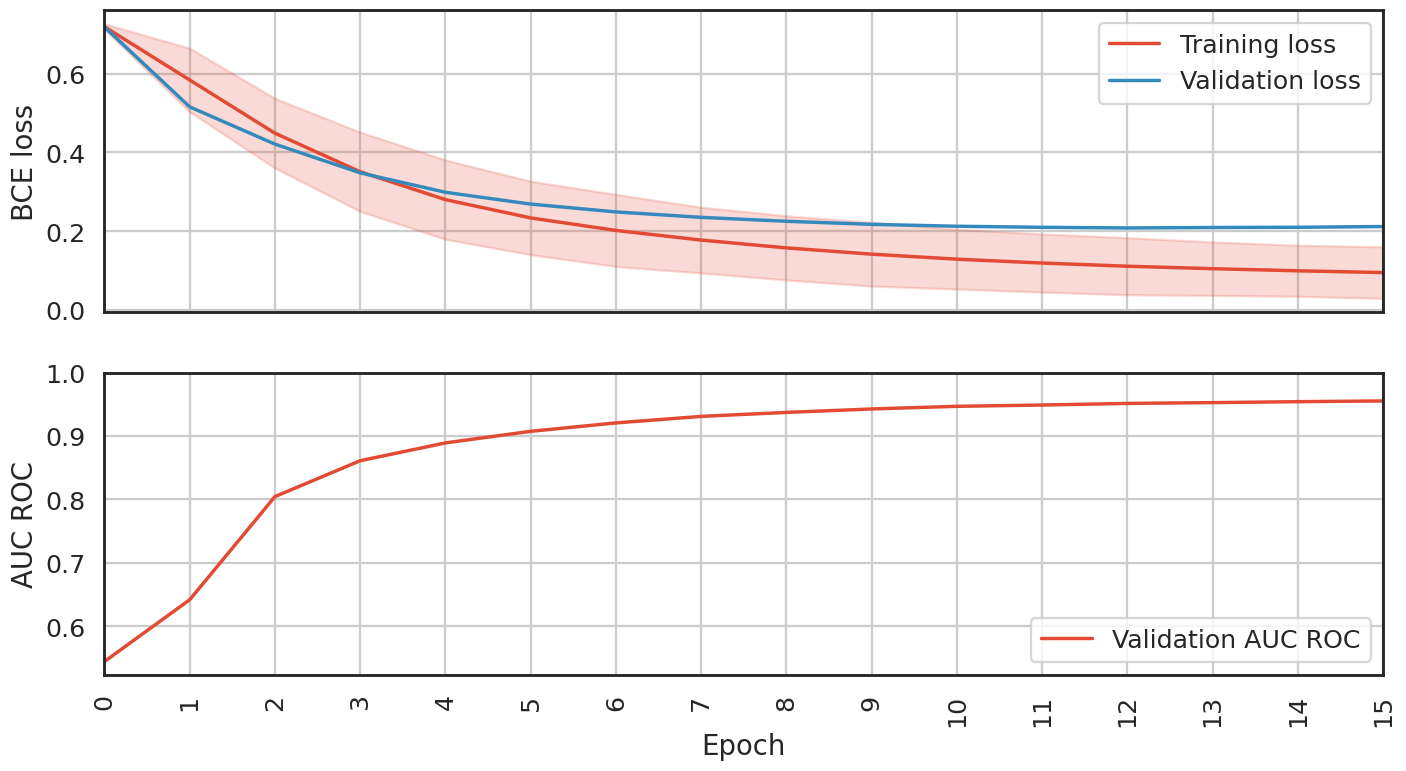

In [6]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(history_tr)
df_vl = pd.DataFrame(history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

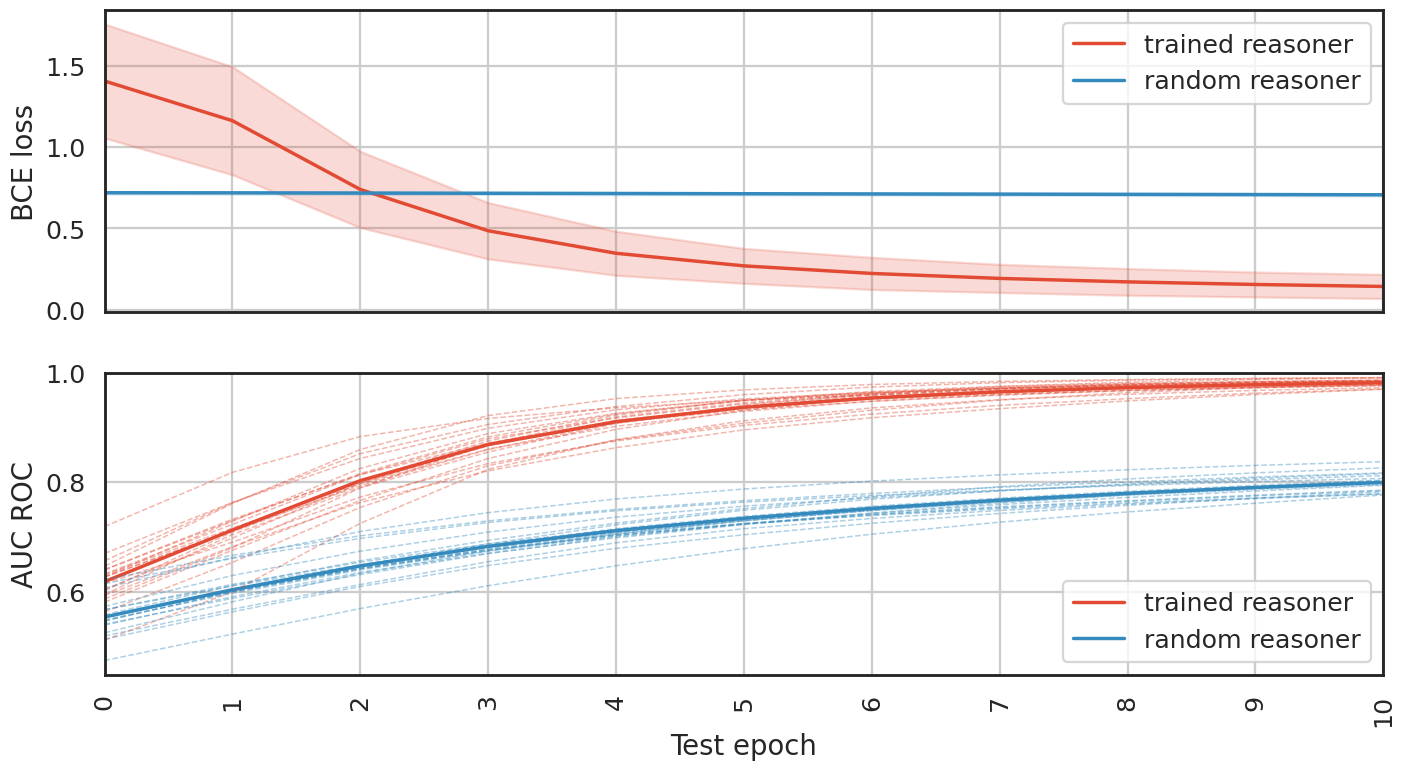

             mean       std     micro
acc      0.952575  0.010609  0.952575
prec     0.962868  0.014443  0.962456
recall   0.826220  0.029855  0.825770
f1       0.889153  0.021932  0.888889
auc_roc  0.981639  0.006497  0.982050
ap       0.960947  0.011706  0.961344
             mean       std     micro
acc      0.276950  0.014430  0.276950
prec     0.240694  0.013466  0.240758
recall   0.997168  0.002465  0.997171
f1       0.387605  0.017429  0.387868
auc_roc  0.799540  0.016425  0.799447
ap       0.632322  0.033967  0.631543


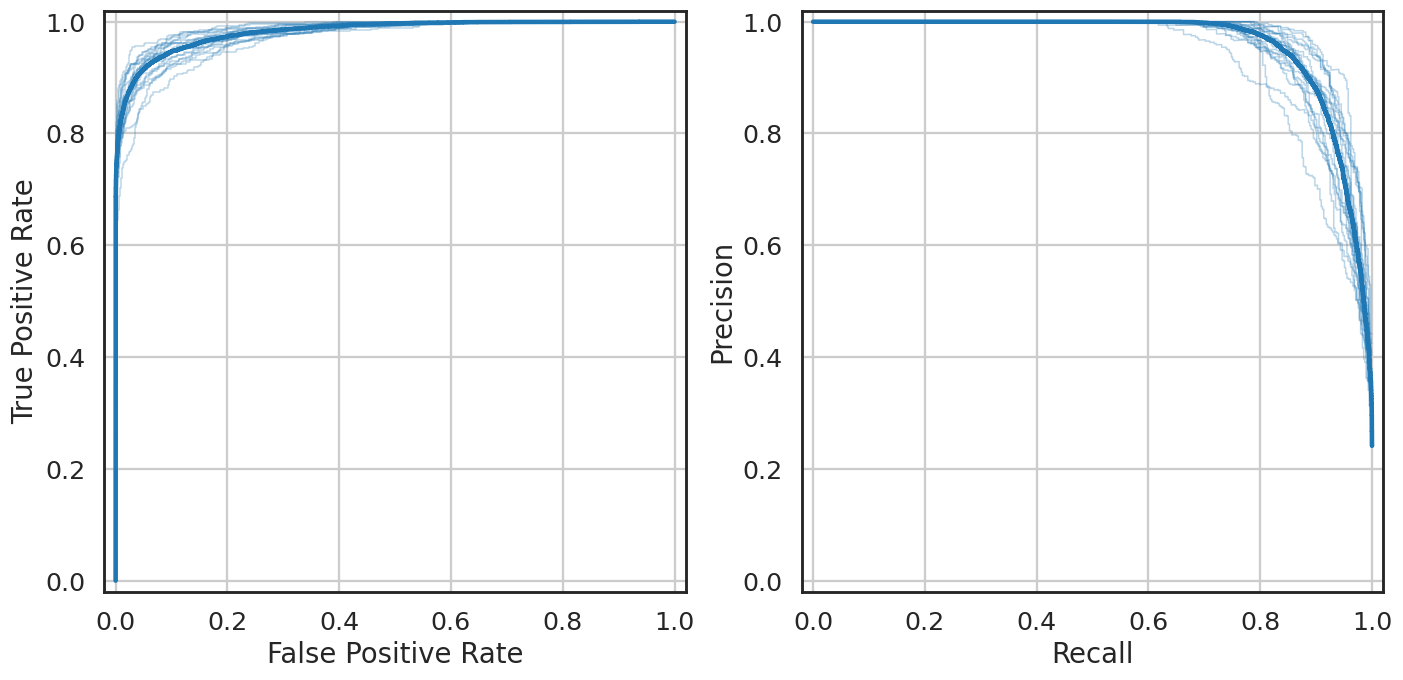

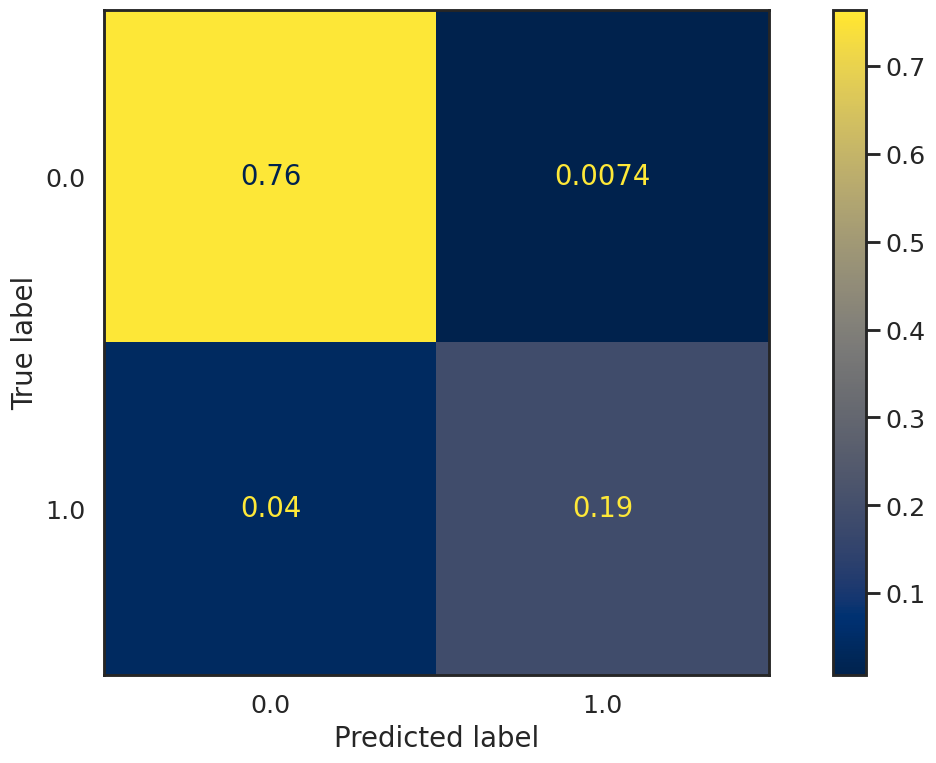

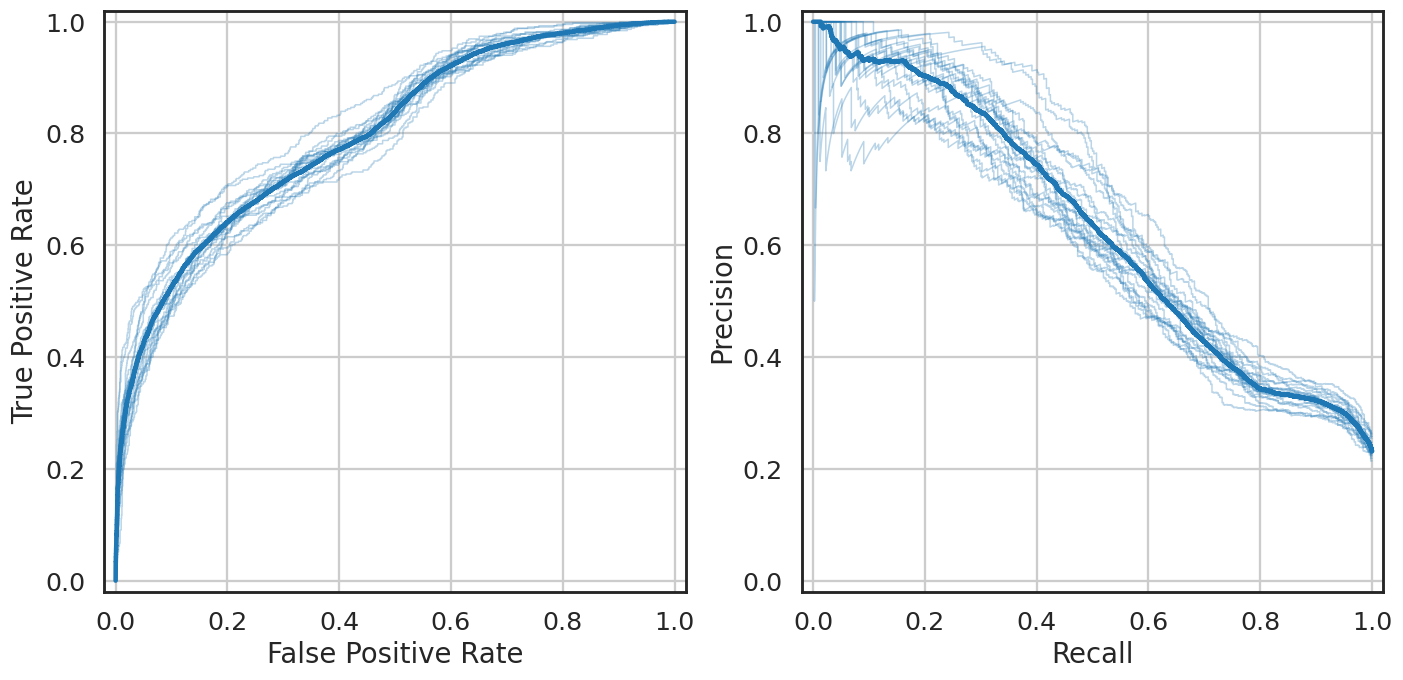

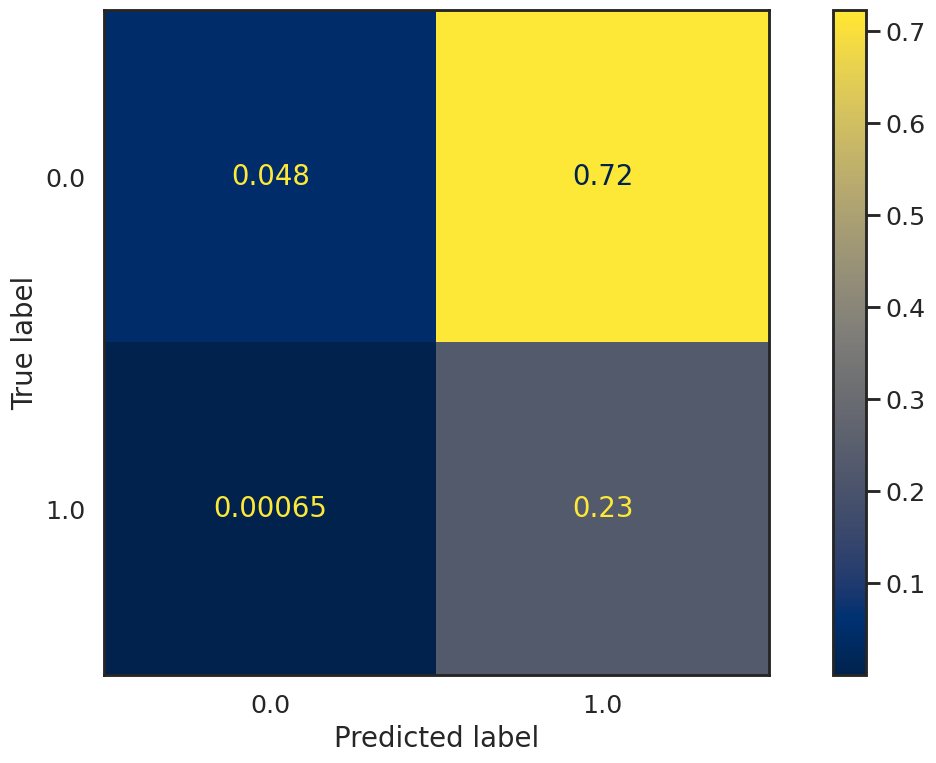

In [7]:
test_history_by_onto = pd.DataFrame(test_history_by_onto)
test_history = pd.DataFrame(test_history)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, Y_te_good, idx_te, save=base+'/%-trained'))
print(report(test_onto, y_te, Y_te_rand, idx_te, save=base+'/%-random'))